- In this notebook I will implement a simple linear regression. Also this does not really fall into the category of deep learning as I'm not building a neural network to do this. But yeah just to learn few concepts related to gradients I'm doing this. I will try to implement the following:
    - Manipulating the gradients
        - Simple gradient descent
        - Momentum based gradient descent
            - Moves faster in the direction where gradients keeps on accumulating
            - Goes past the ideal line to minima due to the momentum
        - NAG (Nesterov Accelerated gradient descent)
            - Controls the overshooting of momentum based gradient descent by looking ahead
    - Manipulating the LR
        - Line Search
        - Other methods of annealing LR we won't implement
            - Step decay
            - Exponential Decay
            - 1/t decay

In [104]:
from cProfile import label

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

from sklearn.datasets import fetch_california_housing

import math

In [3]:
california_housing = fetch_california_housing(as_frame=True)

In [3]:
california_housing

{'data':        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
 0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
 1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
 2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
 3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
 4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
 ...       ...       ...       ...        ...         ...       ...       ...   
 20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
 20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
 20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
 20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
 20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   
 
        Longitude 

In [4]:
print(california_housing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [4]:
X = california_housing['data']
y = california_housing['target']

In [5]:
df = pd.concat([X, y], axis=1)
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [16]:
# from ydata_profiling import ProfileReport
#
# # Generate full EDA report in one command
# ProfileReport(df, explorative=True).to_file("outputs/2_linear_regression/housing_eda_report.html")

In [18]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


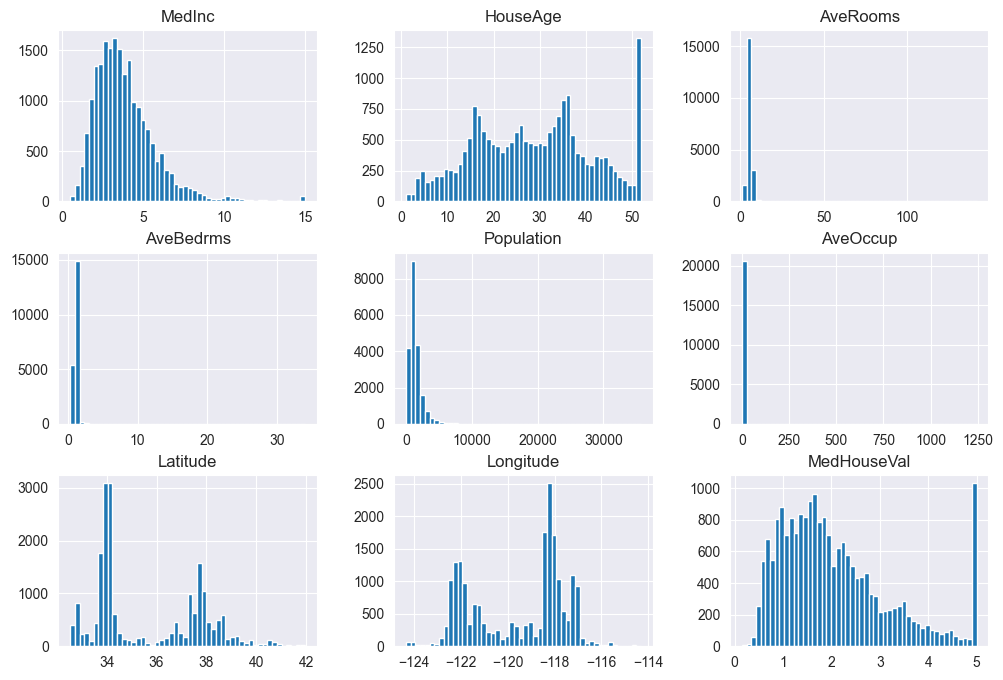

In [14]:
%matplotlib inline
df.hist(figsize=(12, 8), bins=50)
plt.show()

In [10]:
# for col in df.select_dtypes("number").columns:
#     sns.histplot(df[col], kde=False)
#     plt.show()

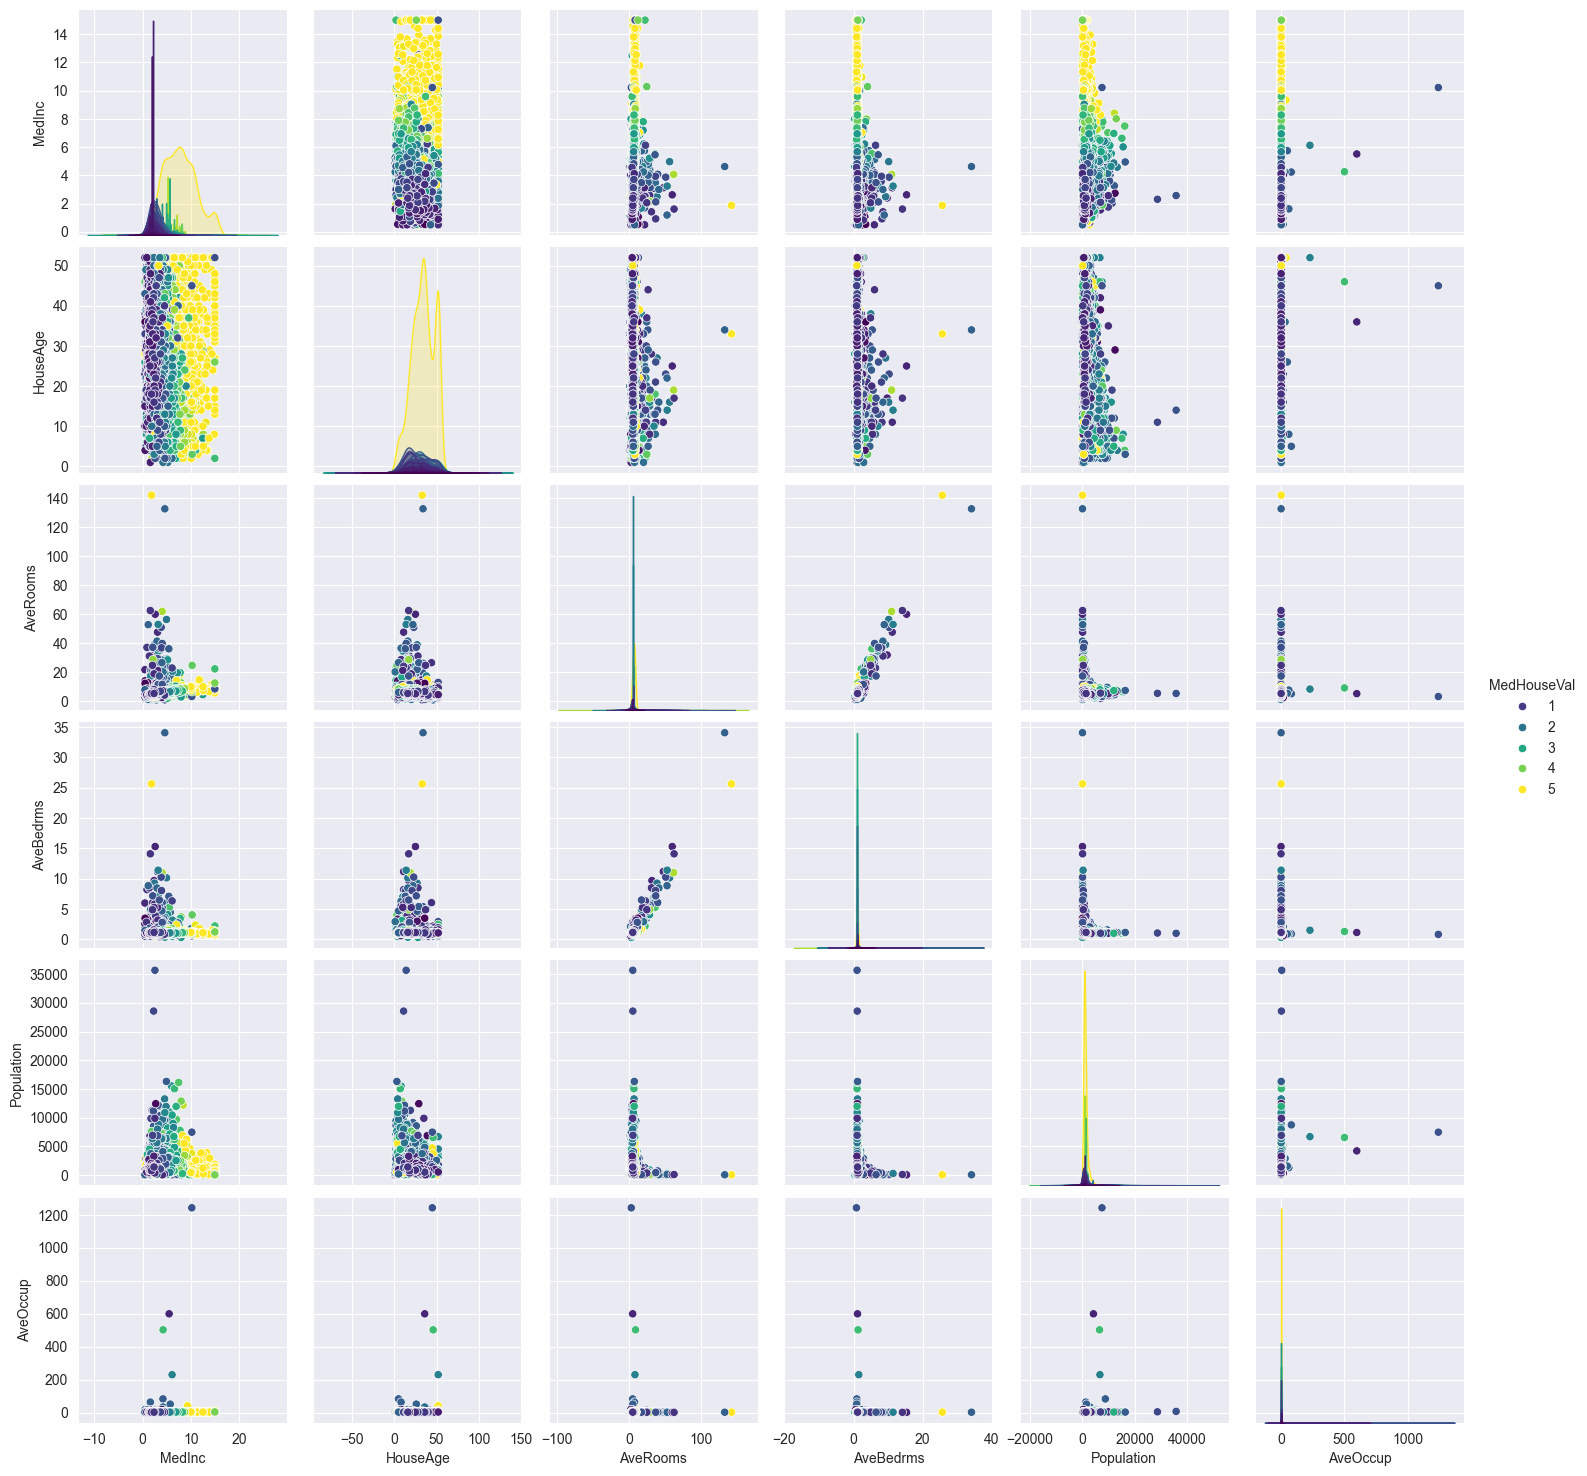

In [18]:
sns.pairplot(df.drop(['Latitude','Longitude'], axis=1), hue="MedHouseVal", palette="viridis")

In [ ]:
# Let's make a basic regression model

In [29]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)
train_x = np.array(train_x)
test_x = np.array(test_x)
train_y = np.array(train_y)
test_y = np.array(test_y)

In [26]:
len(train_x), len(test_x), len(train_y), len(test_y), type(test_x)

(16512, 4128, 16512, 4128, pandas.core.frame.DataFrame)

In [31]:
std = StandardScaler()
train_x_scaled = std.fit_transform(train_x)

# Transform test data
test_x_scaled = std.transform(test_x)

In [65]:
# First build Linear Regression using inbuilt library
lib_reg_model = LinearRegression().fit(train_x_scaled, train_y)
print(f"Train r^2: {lib_reg_model.score(train_x_scaled, train_y)}")
print(f"Test r^2: {lib_reg_model.score(test_x_scaled, test_y)}")

train_y_pred = lib_reg_model.predict(train_x_scaled)
test_y_pred = lib_reg_model.predict(test_x_scaled)

print(f"Train rmse: {root_mean_squared_error(train_y, train_y_pred)}")
print(f"Train rmse: {root_mean_squared_error(test_y, test_y_pred)}")

Train r^2: 0.609869207548491
Test r^2: 0.5882649537217433
Train rmse: 0.715969956619073
Train rmse: 0.7594918211750252


In [107]:
# Now we'll build our own basic regression model
n_feat = len(train_x_scaled[0])
print(f"Number of features: {n_feat}")
'''
So our model has 8 features, w0 is the intercept, w1 to w8 are feature params.
our model that we assume is: y = w0 + w1*feat1 + w2*feat2 + ... + w8*feat8
'''

Number of features: 8


In [146]:
def rmse(y_true, y_pred):
    # sqrt(mean(sum over all i (y_predi - y_truei)*2))

    return root_mean_squared_error(y_true, y_pred)

In [310]:
'''
I am deliberately keeping the lr small to see the effects of other approaches better
'''
# n_iter = 5000
n_iter = 5000
lr = 0.01


In [311]:
# Batch gradient descent
'''
type:
simple: simple gradinet descent
momentum: momentum based gradient descent
    - In momentum based gd our update_t = gamma*update_t-1 + eta*dw_t (eta is lr, update is the gradient)
    - The w's are updated as w_t+1 = w_t - update_t
nag: nesterov accelerated gradient descent
    - In nag gd we do a gradient lookahead on the accumulated gradient history.
        - update_t = gamma*update_t-1 + d(w - gamma*update_t-1)
        - w_t+1 = w_t - lr * update_t
'''


def train(batch_x, batch_y, n_iter, lr, type='simple'):
    loss_val, loss_train = [], []

    np.random.seed(43)
    w = np.random.rand(9, ) # w0 to w8

    update_hist = np.zeros(n_feat+1)
    gamma = 0.9

    for i in range(n_iter):
        n = len(batch_x)

        if type == 'nag':
            w_lookahd = w - gamma*update_hist
        else:
            w_lookahd = w

        # forward pass
        pred_y = np.sum(batch_x*w_lookahd[1:], axis=1) + w_lookahd[0]

        # Calculate loss
        loss = rmse(batch_y, pred_y)

        # Calculate grad
        dw = np.zeros(9,)

        for i in range(n_feat+1):
            if i == 0:
                dw[i] = (1/n)*(math.pow(loss,-1)*(np.sum(pred_y-batch_y)))
            else:
                dw[i] = (1/n)*(math.pow(loss,-1)*(np.sum((pred_y-batch_y)*(batch_x[:,i-1]))))

        # Calculate train and val loss at true w and not w lookahead
        pred_y = np.sum(batch_x*w[1:], axis=1) + w[0]

        # Calculate loss
        loss = rmse(batch_y, pred_y)

        pred_y_val = np.sum(test_x_scaled*w[1:], axis=1) + w[0]
        val_loss = rmse(test_y, pred_y_val)

        loss_train.append(loss)
        loss_val.append(val_loss)
        # print(f"Iter: {i}. Train Loss: {loss}. Val Loss: {val_loss}")

        # backward pass
        if type == 'simple':
            w = w - lr*dw
        else: # momentum or nag
            update_hist = gamma*update_hist + dw
            w = w - lr*update_hist

    # print("\n\n\n")
    return loss_train, loss_val


In [312]:
simple_train_loss, simple_val_loss = train(train_x_scaled, train_y, n_iter, lr, 'simple')
mom_train_loss, mom_val_loss = train(train_x_scaled, train_y, n_iter, lr, 'momentum')
nag_train_loss, nag_val_loss = train(train_x_scaled, train_y, n_iter, lr, 'nag')

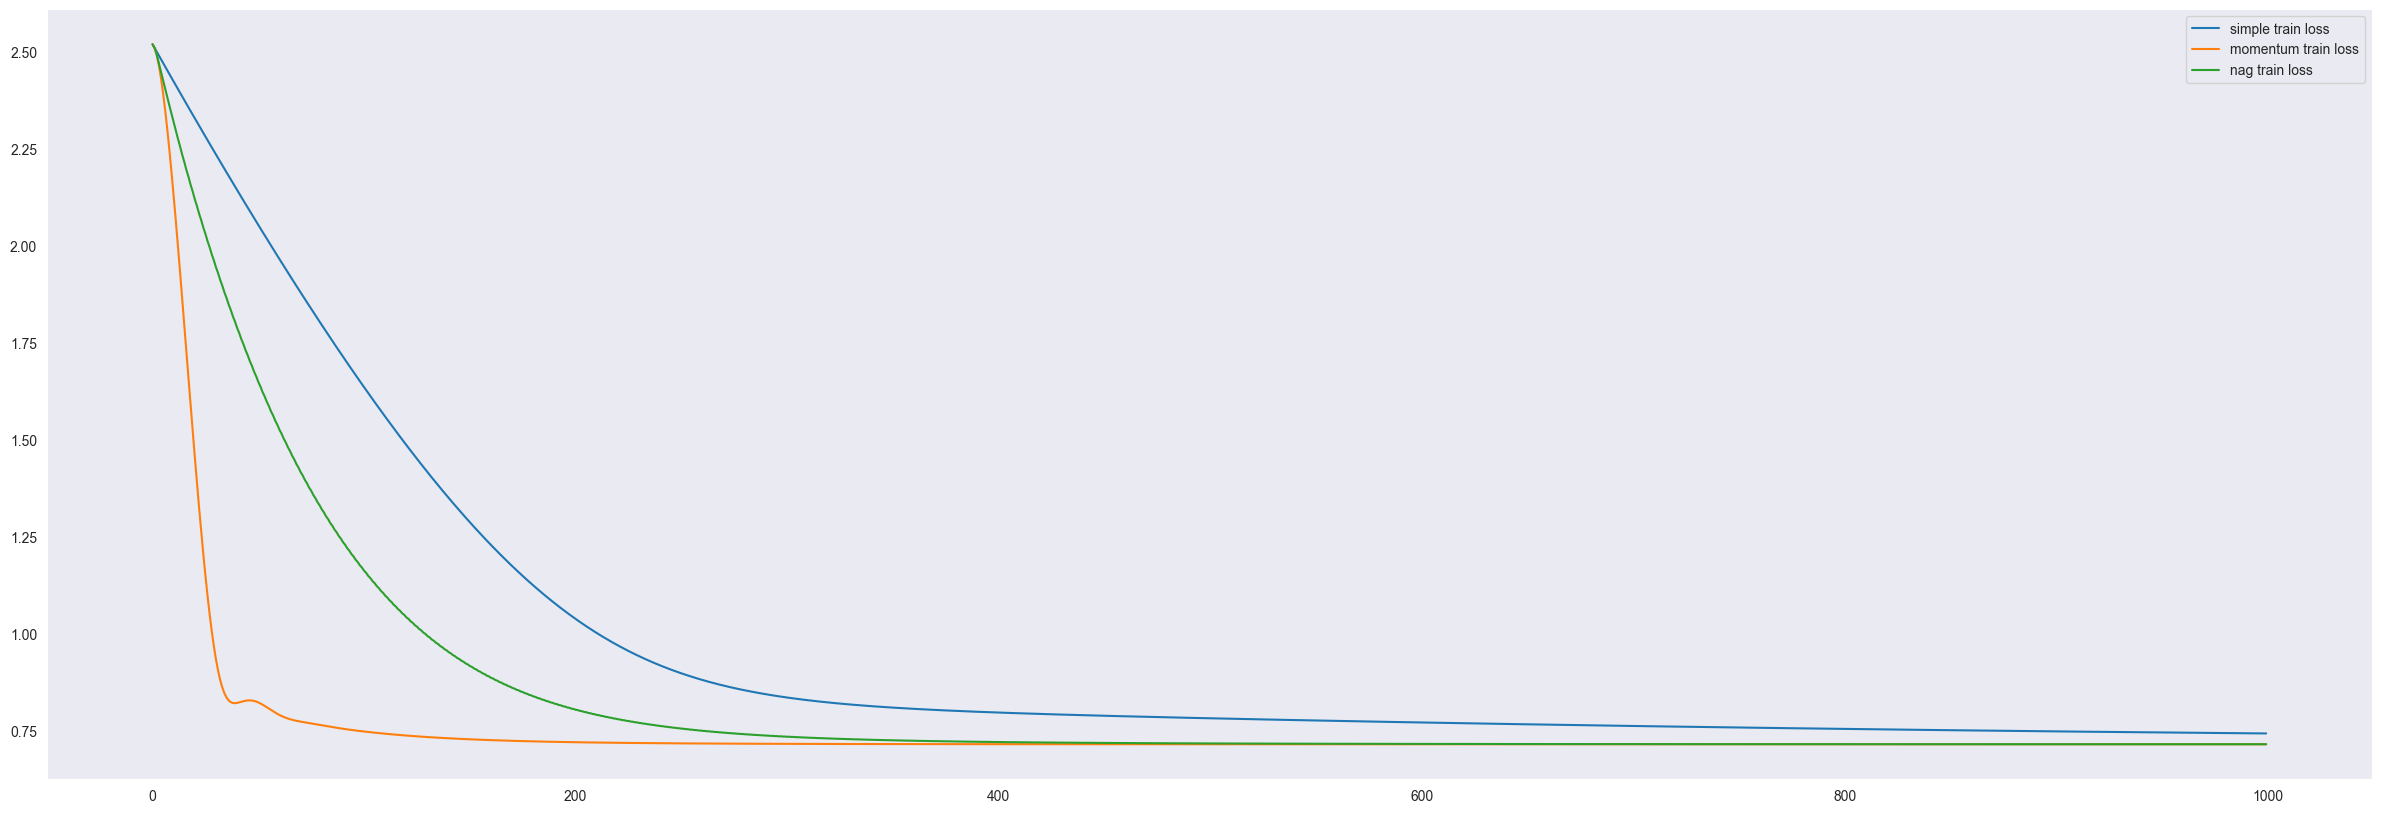

In [318]:
import matplotlib.pyplot as plt

plot_till_iter = 1000
fig = plt.figure(figsize=(30, 10))
plt.plot(simple_train_loss[:plot_till_iter], label="simple train loss")
plt.plot(mom_train_loss[:plot_till_iter], label="momentum train loss")
plt.plot(nag_train_loss[:plot_till_iter], label="nag train loss")

plt.legend()
plt.grid()
plt.show()